# Postmating response in axenic and control _D. melanogaster_ females

Load packages and functions:

In [1]:
## Packages to load
req_packages = c("Biobase", "cluster", "cowplot", 
                 "data.table", "EDASeq", "edgeR", "ggpubr", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", "lattice", 
                 "imager", "pheatmap", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "RUVSeq","splitstackshape", "statmod", "stringr", "tidyverse",
                 "VennDiagram", "viridis")
## load them, quietly
invisible(suppressWarnings(suppressMessages(lapply(req_packages, require, character.only = TRUE))))

## The Cowplot package changes the default themes of ggplot2. Set the bw theme with larger font sizes like so:
theme_set(theme_bw(base_size = 16))
## ... or set the default theme
# theme_set(theme_gray())

## suppress excessive VennDiagram log files
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

NULL

Load custom functions:

In [132]:
source("Functions.R")

Some raw files need to be processed to produce auxiliary files needed below. Running a script in the "Misc" folder should do it:

In [3]:
# system('./Misc/initial_file_modifications.sh')

Load the FlyAtlas2 expression data:

In [4]:
tpm.table_fa2 = read.csv("Annotoations/FlyAtlas2_TPM_table.txt", header = T, sep = "\t")
tpm.matrix_fa2 = read.csv("Annotoations/FlyAtlas2_meanTPM_table.txt", header = T, sep = "\t", row.names = 1)

... and the associated sample information:

In [5]:
sample.info = read.table("Misc/SraRunTable_FlyAtlas2_modified.txt", header = T, sep = "\t")
sample.info = filter(sample.info, RNA == "mRNA")
sample.info = select(sample.info, Library_Name, Replicate_Name, Sex, dev_stage, organism_part, Sample_Name)
sample.info$Library_Name = gsub("Female ", "", sample.info$Library_Name)
sample.info$Library_Name = gsub("Male ", "", sample.info$Library_Name)
sample.info$Library_Name = gsub("Larval ", "", sample.info$Library_Name)
sample.info$Sex = gsub("NA", "unknown", sample.info$Sex)

Load read count data:

In [6]:
counts_bt2 = read.table("eXpress/express.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)

Load annotation files:

In [7]:
annotation = read.csv("Annotoations/fbgn_annotation_ID_fb_2018_04_mod.tsv", header = T, check.names = F, sep ="\t")

Load the gene snapshot data:

In [8]:
snapshots = read.csv("Annotoations/gene_snapshots_fb_2018_05.tsv", header = T, sep ="\t", quote = "")

Load the known immunity genes from Sackton *et al* 2008:

In [9]:
immunity_genes.df = read.csv("Annotoations/mel_immunity_genes.txt", header = T, sep = "\t", check.names = F)
immunity_genes = as.character(immunity_genes.df$FlyBaseID)

Load the transcript lengths for the eXpress data:

In [10]:
bt2_trans_lengths = read.csv("eXpress/transcriptome/transcript_lengths.txt", header = T, sep = "\t")

Load the gene-to-transcript mapping:

In [11]:
gene_trans_map = read.table("eXpress/transcriptome/dmel-all-transcript-r6.23.gene_trans_map", header = F, sep = "\t")
colnames(gene_trans_map) = c("gene_id", "transcript_id")

Generate a gene length object for the eXpress data:

In [12]:
# Merge transcript length file with gene-to-trans file:
tmpMrge = merge(bt2_trans_lengths, gene_trans_map)
# Select only the length and gene_id columns
tmpMrge = as.data.table(subset(tmpMrge, select = c("length", "gene_id")))
# For each gene ID entry, select the entry with largest value in the "length" column:
bt2_gene_lengths = tmpMrge[tmpMrge[, .I[which.max(length)], by=gene_id]$V1]
# remove un-needed intermediate objects
rm(tmpMrge)

Generate sample info object:

In [13]:
sampleData = read.table("Misc/samples.txt", header = F, check.names = F, fill = T)
sampleInfo = sampleData
colnames(sampleInfo) = c("Sample", "Replicate")

sampleInfo$Female = ifelse(grepl("^A",sampleInfo$Sample), "axenic", "control")

sampleInfo$Male = ifelse(grepl("A$", sampleInfo$Sample), "axenic", ifelse(grepl("C$", sampleInfo$Sample), "control", "none"))

sampleInfo$Handler = ifelse(grepl("3|4", sampleInfo$Replicate), "Yasir", "Sofie")

sampleInfo$Status = ifelse(grepl("none", sampleInfo$Male), "virgin", "mated")

Generate a TPM table from the counts. Use any arbitrary number for lengths since this is 3prime data:

In [14]:
tpm_bt2 <- apply(counts_bt2, 2, function(x) tpm(x, 2000))

Reshape the TPM matrix to calculate means and generate heatmaps and individual gene plots later:

In [15]:
tmp.tpmMatrix<-tpm_bt2
# colnames(tmp.tpmMatrix) <- sampleInfo$Sample
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "replicate", "TPM")
tmp.tpmMatrix.m <- merge(tmp.tpmMatrix.m, sampleInfo, by.x = "replicate", by.y = "Replicate", all.x = T)
tmp.tpmMatrix.m$replicate = gsub(".*_", "", tmp.tpmMatrix.m$replicate)
annot.sub = subset(annotation, select = c("primary_FBgn", "gene_symbol", "annotation_ID"))
tmp.tpmMatrix.m = merge(tmp.tpmMatrix.m, annot.sub, by.x = "gene_id", by.y = "primary_FBgn", all.x = T)
# tmp.tpmMatrix.m = merge
tpm.table = tmp.tpmMatrix.m
tpm.table$Male = factor(tpm.table$Male, levels = c("none", "axenic", "control"))
tpm.table$Status = factor(tpm.table$Status, levels = c("virgin", "mated"))
rm(tmp.tpmMatrix.m)

the `geneBoxPlot` function can be used for single gene tpm boxplots of the data:

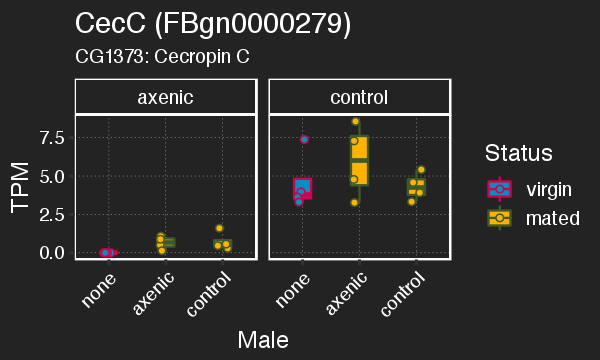

In [16]:
options(repr.plot.width = 5, repr.plot.height = 3)
geneBoxPlot_mon("CecC", show_reps = F) + theme_monokai_full()

There's also a plotting function for the Fly Atlas data:

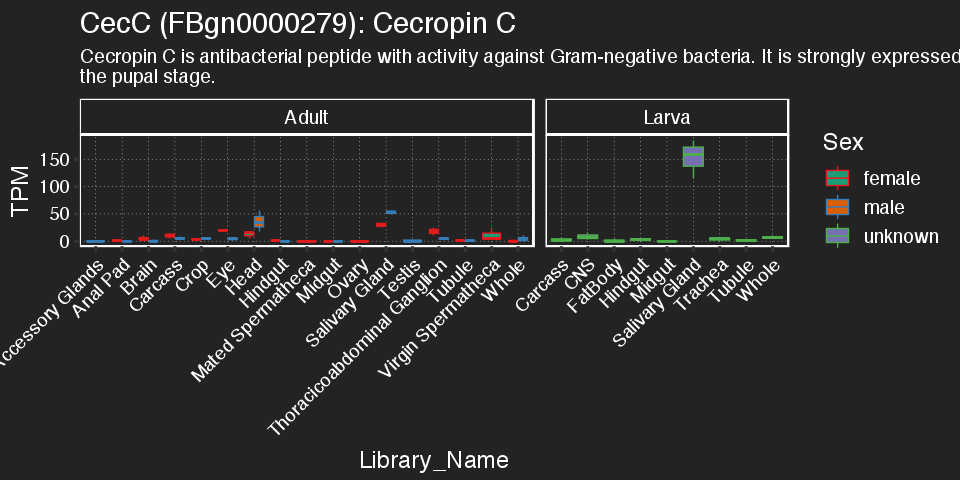

In [17]:
options(repr.plot.width = 8, repr.plot.height = 4)
geneBoxPlot_fa2(tpm.table_fa2, "CecC")

For heatmaps, we can make some modifications to the output format:

In [18]:
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

Output library size object:

In [19]:
LibSizes <- as.data.frame(colSums(counts_bt2))
libSizes <- cbind(sample = row.names(LibSizes), LibSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("replicate", "counts")
libSizes$sample = gsub("_.*", "", libSizes$replicate)

Make a barplot of library sizes:

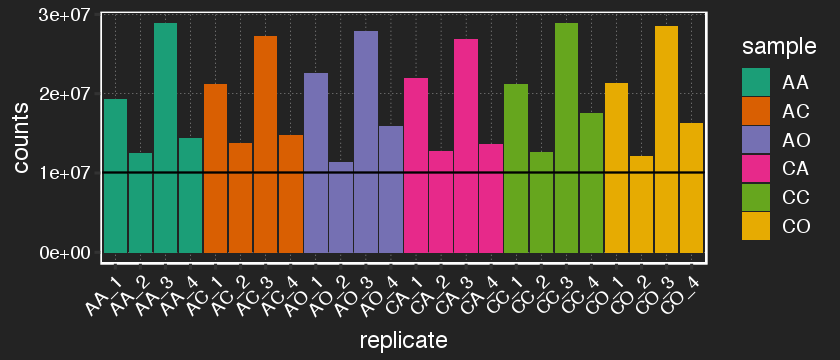

In [20]:
options(repr.plot.width = 7, repr.plot.height = 3)
# pdf("Figures/Library_sizes.pdf", width = 12, height = 4)
ggplot(libSizes, aes(replicate, counts, fill = sample)) + 
    geom_bar(stat="identity", position = "dodge") + 
    theme_monokai_full() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    geom_hline(yintercept = 10000000) +
    scale_fill_brewer(palette="Dark2") 
# dev.off()

### Differential expression analysis (eXpress):

First, filter out genes with very low expression from the counts matrix. We'll use a minimum cutoff of 1 CPM in at least 4 samples:

In [21]:
# counts_bt2 = subset(counts_bt2, rownames(counts_bt2) %!in% wierd_genes)
cpm_bt2 <- cpm(counts_bt2)
thresh_bt2 <- cpm_bt2 > 1
keep_bt2 <- rowSums(thresh_bt2) >= 4
countsKeep_bt2 <- counts_bt2[keep_bt2,]
# countsKeep_bt2 <- subset(countsKeep_bt2, rownames(countsKeep_bt2) %!in% wierd_genes)
table(keep_bt2)

keep_bt2
FALSE  TRUE 
 6282  7649 

Now define the groupings by sample and set up the design matrix:

In [174]:
groups = factor(sampleInfo$Sample)
design = model.matrix( ~ 0 + groups)
colnames(design) <- levels(groups)
rownames(design) <- sampleInfo$Replicate

Set up an alternative design matrix that accounts for the handler batch effect:

In [175]:
batch = factor(sampleInfo$Handler)
design_batch = model.matrix( ~ 0 + groups + batch)
colnames(design_batch) <- c(levels(groups), "batch")
rownames(design_batch) <- sampleInfo$Replicate

Create the DGElist object and GLM fit:

In [176]:
dgeList_lrt_q <- DGEList(counts = countsKeep_bt2, group = groups)
dgeList_lrt_q <- calcNormFactors(dgeList_lrt_q)
dgeList_lrt_q <- estimateGLMCommonDisp(dgeList_lrt_q, design)
dgeList_lrt_q <- estimateGLMTagwiseDisp(dgeList_lrt_q, design)
dgeList_lrt_q_fit <- glmQLFit(dgeList_lrt_q, design)
summary(dgeList_lrt_q$tagwise.dispersion)

## Obtain the residuals with RUVseq
set1 <- newSeqExpressionSet(as.matrix(round(countsKeep_bt2)), phenoData = data.frame(groups, row.names=colnames(countsKeep_bt2)))
res <- residuals(dgeList_lrt_q_fit, type="deviance")
set2 <- RUVr(set1, rownames(countsKeep_bt2), k=1, res)
design <- model.matrix(~ 0 + groups + W_1, data=pData(set2))
colnames(design) = gsub("groups", "", colnames(design))

## Apply residuals to new dgeList object
dgeList_lrt_q <- DGEList(counts = counts(set2), group = groups)
dgeList_lrt_q <- calcNormFactors(dgeList_lrt_q)
dgeList_lrt_q <- estimateGLMCommonDisp(dgeList_lrt_q, design)
dgeList_lrt_q <- estimateGLMTagwiseDisp(dgeList_lrt_q, design)
dgeList_lrt_q_fit <- glmQLFit(dgeList_lrt_q, design)
summary(dgeList_lrt_q$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03664 0.05950 0.07603 0.13301 0.12090 4.43359 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01478 0.03325 0.04404 0.06629 0.06705 2.99738 

Make a separate DGElist object for the batch fit:

In [256]:
dgeList_batch <- DGEList(counts = countsKeep_bt2, group = groups)
dgeList_batch <- calcNormFactors(dgeList_batch)
dgeList_batch <- estimateGLMCommonDisp(dgeList_batch, design_batch)
dgeList_batch <- estimateGLMTagwiseDisp(dgeList_batch, design_batch)
dgeList_batch_fit <- glmQLFit(dgeList_batch, design_batch)
summary(dgeList_batch$tagwise.dispersion)

# ## Obtain the residuals with RUVseq
# set3 <- newSeqExpressionSet(as.matrix(round(countsKeep_bt2)), phenoData = data.frame(groups, row.names=colnames(countsKeep_bt2)))
# res <- residuals(dgeList_batch_fit, type="deviance")
# set4 <- RUVr(set3, rownames(countsKeep_bt2), k=1, res)
# design_batch <- model.matrix(~ 0 + groups + W_1, data=pData(set4))
# colnames(design_batch) = gsub("groups", "", colnames(design_batch))

# ## Apply residuals to new dgeList object
# dgeList_batch <- DGEList(counts = counts(set4), group = groups)
# dgeList_batch <- calcNormFactors(dgeList_batch)
# dgeList_batch <- estimateGLMCommonDisp(dgeList_batch, design_batch)
# dgeList_batch <- estimateGLMTagwiseDisp(dgeList_batch, design_batch)
# dgeList_batch_fit <- glmQLFit(dgeList_batch, design_batch)
# summary(dgeList_batch$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01502 0.03353 0.04441 0.06642 0.06830 2.96768 

Chose one of those two DGE list objects for the preceding analyses:

In [257]:
# # no batch QLM
# dgeList = dgeList_lrt_q
# dgeList_fit = dgeList_lrt_q_fit

# # batch
dgeList = dgeList_batch
dgeList_fit = dgeList_batch_fit

Look at BCV and QQ plot:

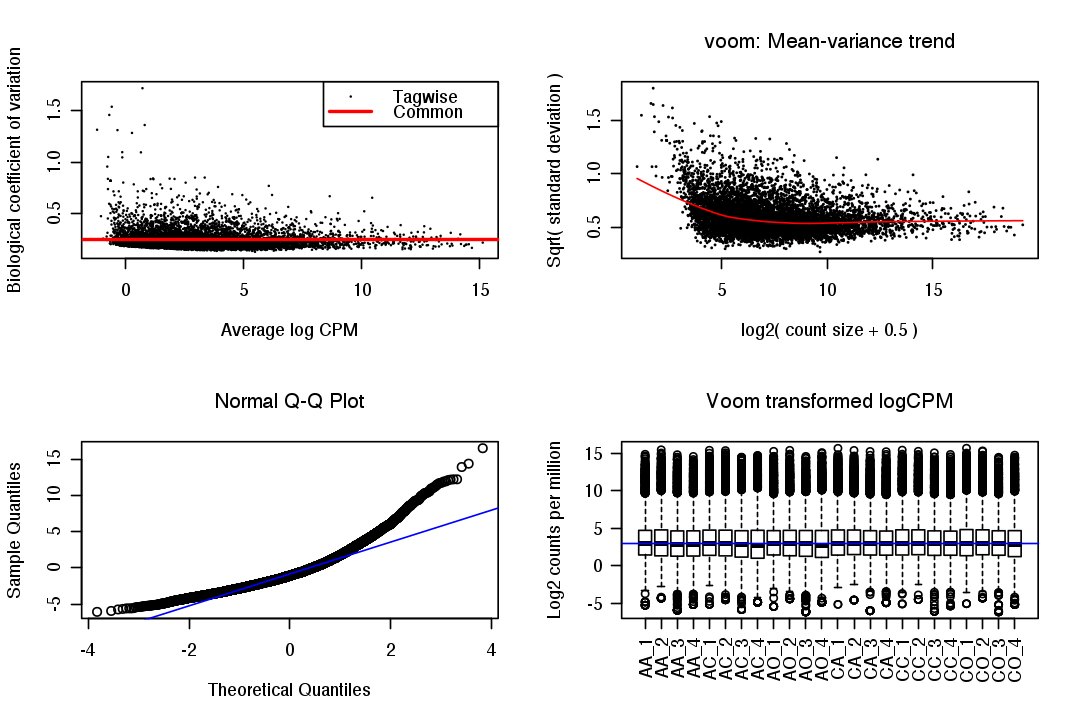

In [258]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList)
# mean-variance trend
virgin.voom = voom(dgeList, design, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(virgin.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(virgin.voom$E),col="blue")

rm(virgin.voom, g.v, z.v)


Generate a correlation plot between replicates:

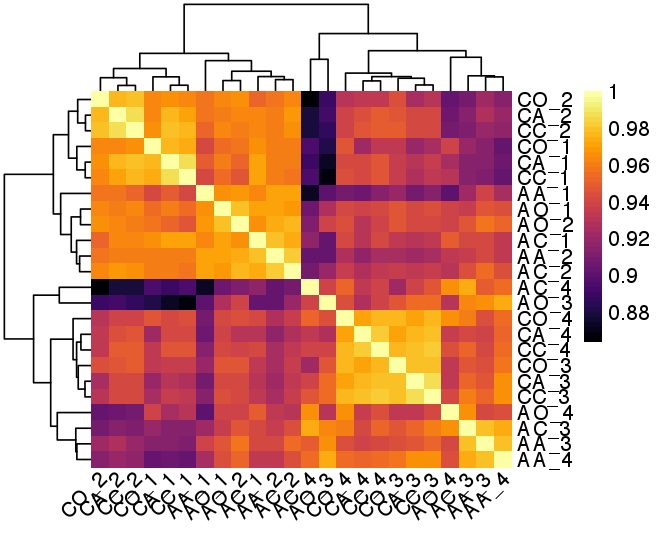

In [193]:
## Plot sample correlation
data = log2(counts(set4)+1)
# colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

options(repr.plot.width = 5.5, repr.plot.height = 4.5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(50),
  border_color      = NA,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   filename          = "Figures/sample_correlations_all.pdf",
#   width             = 6, 
#   height            = 5,
  fontsize          = 12    
)
rm(data)
rm(sample_cor)

Hmmmm.... wierd groupings by replicate. Look at an MDS plot:

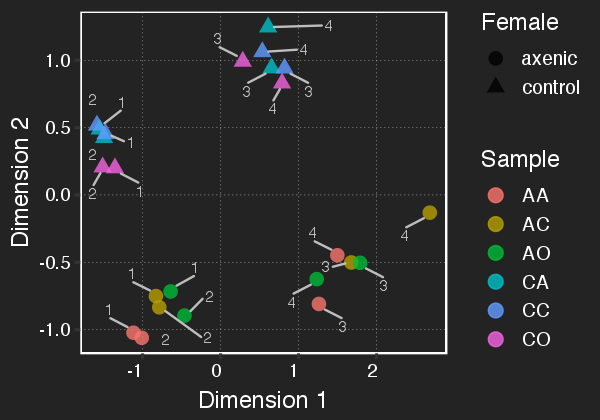

In [194]:
options(repr.plot.width = 5, repr.plot.height = 3.5)
c.mds.gg(dgeList) + theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

Something funny is going on with replicate grouping. First we'll explore the results without doing anything about the replicates. 

Before running the likelihood ration tests, we'll make an FBgn-to-gene symbol object to append to the tTags tables:

In [195]:
FBgn_to_symbol = subset(annotation, select = c("gene_symbol", "primary_FBgn"))

We'll also set up all the relevant contrasts. First for the LRT-based test:

In [196]:
# # pairwise contrasts
# virgin_contrasts <- makeContrasts(CO-AO, levels=design)
# AA.v.AO_contrasts <- makeContrasts(AA-AO, levels=design)
# AC.v.AO_contrasts <- makeContrasts(AC-AO, levels=design)
# CA.v.CO_contrasts <- makeContrasts(CA-CO, levels=design)
# CC.v.CO_contrasts <- makeContrasts(CC-CO, levels=design)

# # male effect
# male.effect.A.background <- makeContrasts( AA-AC, levels = design)
# male.effect.C.background <- makeContrasts( CA-CC, levels = design)

# # female effect:
# A.female.effect <- makeContrasts( ((AA-AO)+(AC-AO))/2 - ((CA-CO)+(CC-CO))/2, levels = design)
# A.male.effect <- makeContrasts( ((AA-AO)+(CA-CO))/2 - ((CC-CO)+(AC-AO))/2, levels = design)

# # mated female effect:
# AA.effect <- makeContrasts( (AA-AO) - ((AC-AO)+(CC-CO)+(CA-CO))/3, levels=design)
# AC.effect <- makeContrasts( (AC-AO) - ((AA-AO)+(CC-CO)+(CA-CO))/3, levels=design)
# CA.effect <- makeContrasts( (CA-CO) - ((AC-AO)+(CC-CO)+(AA-AO))/3, levels=design)
# CC.effect <- makeContrasts( (CC-CO) - ((AC-AO)+(AA-AO)+(CA-CO))/3, levels=design)

.. and the QL-based test:

In [259]:
# pairwise contrasts
virgin_contrasts <- makeContrasts(CO-AO, levels=design_batch)
AA.v.AO_contrasts <- makeContrasts(AA-AO, levels=design_batch)
AC.v.AO_contrasts <- makeContrasts(AC-AO, levels=design_batch)
CA.v.CO_contrasts <- makeContrasts(CA-CO, levels=design_batch)
CC.v.CO_contrasts <- makeContrasts(CC-CO, levels=design_batch)

# male effect
male.effect.A.background <- makeContrasts( AA-AC, levels = design_batch)
male.effect.C.background <- makeContrasts( CA-CC, levels = design_batch)

# female effect:
A.female.effect <- makeContrasts( ((AA-AO)+(AC-AO))/2 - ((CA-CO)+(CC-CO))/2, levels = design_batch)
A.male.effect <- makeContrasts( ((AA-AO)+(CA-CO))/2 - ((CC-CO)+(AC-AO))/2, levels = design_batch)

# mated female effect:
AA.effect <- makeContrasts( (AA-AO) - ((AC-AO)+(CC-CO)+(CA-CO))/3, levels=design_batch)
AC.effect <- makeContrasts( (AC-AO) - ((AA-AO)+(CC-CO)+(CA-CO))/3, levels=design_batch)
CA.effect <- makeContrasts( (CA-CO) - ((AC-AO)+(CC-CO)+(AA-AO))/3, levels=design_batch)
CC.effect <- makeContrasts( (CC-CO) - ((AC-AO)+(AA-AO)+(CA-CO))/3, levels=design_batch)

First look at the difference between the axenic and control virgin samples:

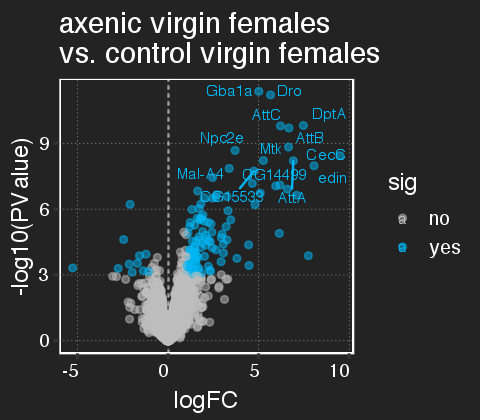

In [260]:
# run the LRT and extract the DE table
lrt.virgins.table <- edge.DE(dgeList_fit, virgin_contrasts, LRT = F)
virgins_sigGenes = subset(lrt.virgins.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
# pdf("Figures/virgin_female_contrast.pdf", width = 4, height = 3.5)
(virgin_contrasts_volcano.gg = edge.DE.gg(lrt.virgins.table) +
                                scale_colour_manual(values = c("gray","#00b6f3")) +
                                geom_text_repel(data = filter(lrt.virgins.table, sig == "yes" & -log10(PValue) > 7.5),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3) +
                                labs(title = "axenic virgin females \nvs. control virgin females", size = 2) +
                                theme_monokai_full() + theme(axis.text.x = element_text(angle = 0)))
# dev.off()

Look at a heatmap of these results

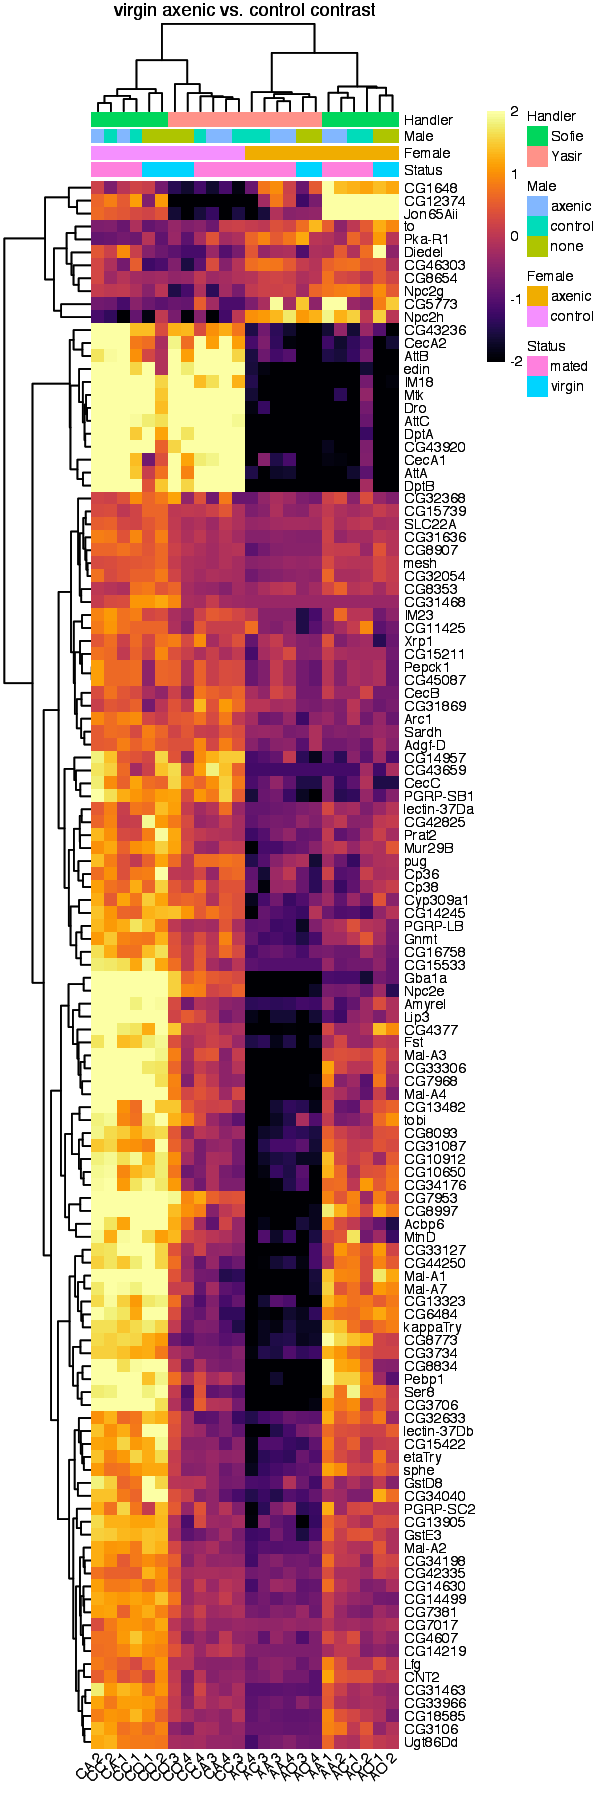

In [261]:
options(repr.plot.width = 5, repr.plot.height = 15)
heatmap_fa2(tpm_bt2, virgins_sigGenes, fly_atlas = F, title = "virgin axenic vs. control contrast")

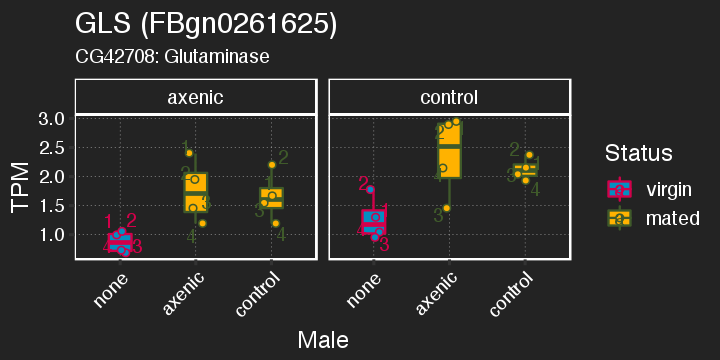

In [208]:
options(repr.plot.width = 6, repr.plot.height = 3)
geneBoxPlot_mon("GLS", show_reps = T) + theme_monokai_full()

Output individual gene plots:

In [203]:
# virgins_sigGenes.Plots = suppressMessages(lapply(virgins_sigGenes, geneBoxPlot, show_reps = T))
# ggsave("Figures/virgins_sigGenes.Plots.pdf", marrangeGrob(grobs = virgins_sigGenes.Plots, nrow = 2, ncol =2))

And output snapshot summary:

In [204]:
# tempInfo = filter(snapshots, FBgn_ID %in% virgins_sigGenes)
# tempInfo = select(tempInfo, -datestamp)
# write.table(tempInfo, "Results/virgins_sigGenes.txt", quote = F, sep = "\t", row.names = F)

Now compare the mated axenic females to virgin axenic females. First, females mated to axenic males

In [205]:
# run the LRT and extract the DE table
lrt.AA.v.AO.table <- edge.DE(dgeList_fit, AA.v.AO_contrasts)
AA.v.AO_sigGenes = subset(lrt.AA.v.AO.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
AA.v.AO_contrasts_volcano.gg = edge.DE.gg(lrt.AA.v.AO.table) +
                                scale_colour_manual(values = c("gray","#33ed5a")) +
                                geom_text_repel(data = filter(lrt.AA.v.AO.table, sig == "yes" & -log10(PValue) > 5),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3) +
                                labs(title = "axenic females X axenic males\nvs. axenic virgin females", size = 2) +
                                theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

... and females mated to control males

In [206]:
# run the LRT and extract the DE table
lrt.AC.v.AO.table <- edge.DE(dgeList_fit, AC.v.AO_contrasts)
AC.v.AO_sigGenes = subset(lrt.AC.v.AO.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
AC.v.AO_contrasts_volcano.gg = edge.DE.gg(lrt.AC.v.AO.table) +
                                scale_colour_manual(values = c("gray","#33ed5a")) +
                                geom_text_repel(data = filter(lrt.AC.v.AO.table, sig == "yes" & -log10(PValue) > 5),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3) +
                                labs(title = "axenic females X control males\nvs. axenic virgin females", size = 2) +
                                theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

Show those volcano plots:

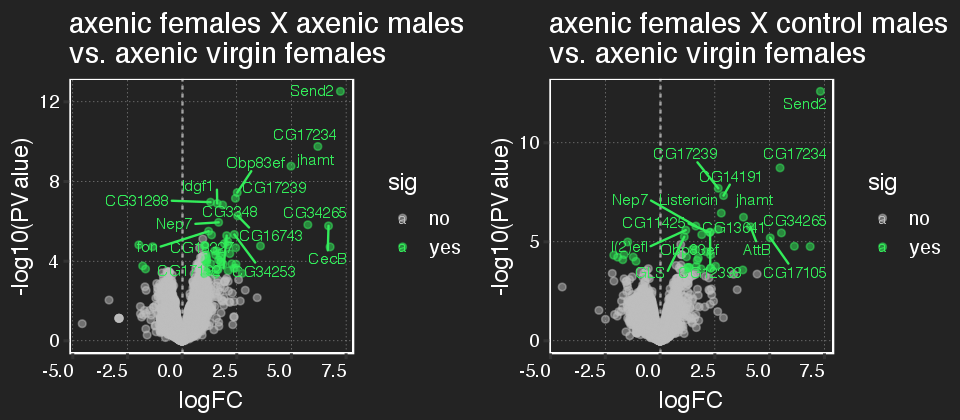

In [254]:
options(repr.plot.width = 8, repr.plot.height = 3.5)
# pdf("Figures/mated_axenic_female_contrasts.pdf", width = 8, height = 3.5)
plot_grid(AA.v.AO_contrasts_volcano.gg, AC.v.AO_contrasts_volcano.gg, ncol = 2)
# dev.off()

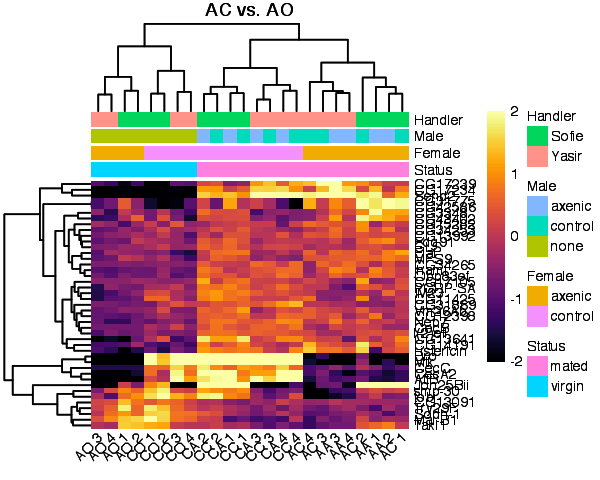

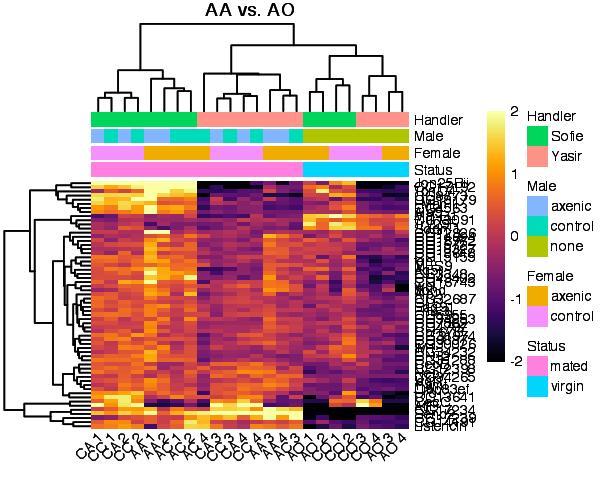

In [255]:
options(repr.plot.width = 5, repr.plot.height = 4)
heatmap_fa2(tpm_bt2, AC.v.AO_sigGenes, fly_atlas = F, title = "AC vs. AO")
heatmap_fa2(tpm_bt2, AA.v.AO_sigGenes, fly_atlas = F, title = "AA vs. AO")

Now let's look at the control females. First, females mated to axenic males

In [143]:
# run the LRT and extract the DE table
lrt.CA.v.CO.table <- edge.DE(dgeList_fit, CA.v.CO_contrasts)
CA.v.CO_sigGenes = subset(lrt.CA.v.CO.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CA.v.CO_contrasts_volcano.gg = edge.DE.gg(lrt.CA.v.CO.table) +
                                scale_colour_manual(values = c("gray","#f38195")) +
                                geom_text_repel(data = filter(lrt.CA.v.CO.table, sig == "yes" & -log10(PValue) > 5),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3) +
                                labs(title = "control females X axenic males\nvs. control virgin females", size = 2) +
                                theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

... and females mated to control males

In [144]:
# run the LRT and extract the DE table
lrt.CC.v.CO.table <- edge.DE(dgeList_fit, CC.v.CO_contrasts)
CC.v.CO_sigGenes = subset(lrt.CC.v.CO.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CC.v.CO_contrasts_volcano.gg = edge.DE.gg(lrt.CC.v.CO.table) +
                                scale_colour_manual(values = c("gray","#f38195")) +
                                geom_text_repel(data = filter(lrt.CC.v.CO.table, sig == "yes" & -log10(PValue) > 5),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3) +
                                labs(title = "control females X control males\nvs. control virgin females", size = 2) +
                                theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

Show those volcano plots:

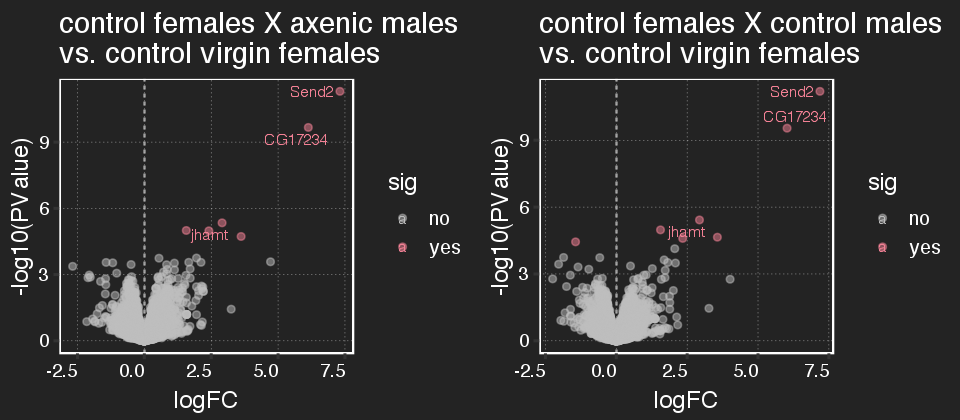

In [145]:
options(repr.plot.width = 8, repr.plot.height = 3.5)
# pdf("Figures/mated_control_female_contrasts.pdf", width = 8, height = 3.5)
plot_grid(CA.v.CO_contrasts_volcano.gg, CC.v.CO_contrasts_volcano.gg, ncol = 2)
# dev.off()

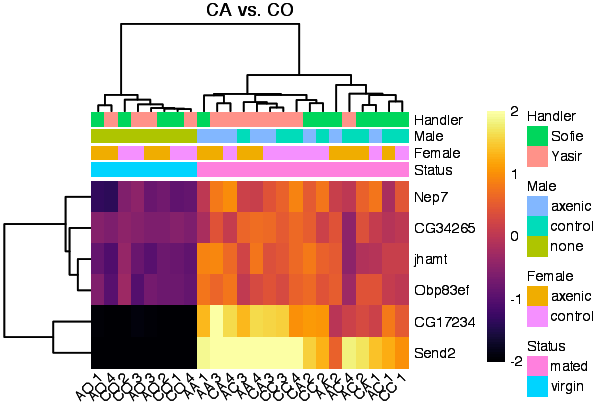

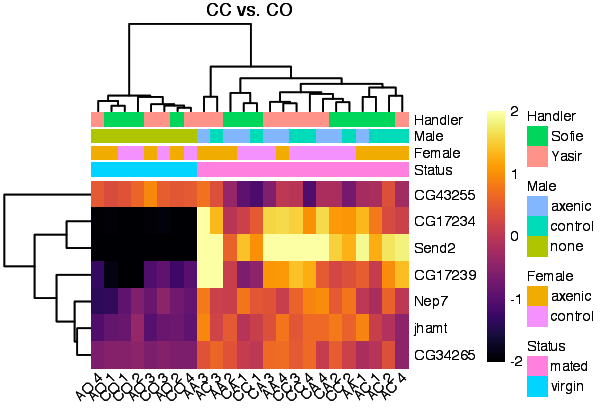

In [151]:
options(repr.plot.width = 5, repr.plot.height = 3.5)
heatmap_fa2(tpm_bt2, CA.v.CO_sigGenes, fly_atlas = F, title = "CA vs. CO")
heatmap_fa2(tpm_bt2, CC.v.CO_sigGenes, fly_atlas = F, title = "CC vs. CO")

Let's make a point plot comparing the log fold-change between axenic and control females after mating to control males:

In [162]:
options(repr.plot.width = 4, repr.plot.height = 3.5)
AA.v.AO_x_AC.v.AO = diag.plot(lrt.AA.v.AO.table, lrt.AC.v.AO.table) + theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))
CC.v.CO_x_CA.v.CO = diag.plot(lrt.CC.v.CO.table, lrt.CA.v.CO.table) + theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

Now output all these plots:

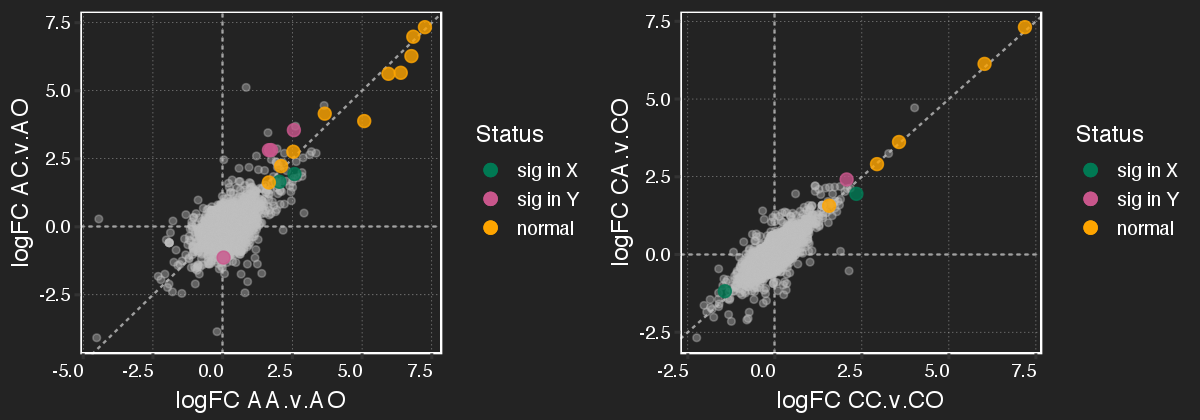

In [163]:
options(repr.plot.width = 10, repr.plot.height = 3.5)
# pdf("Figures/logFC_pointPlots_allReps.pdf", width = 9, height = 7)
plot_grid(AA.v.AO_x_AC.v.AO, CC.v.CO_x_CA.v.CO, ncol = 2)
# dev.off()

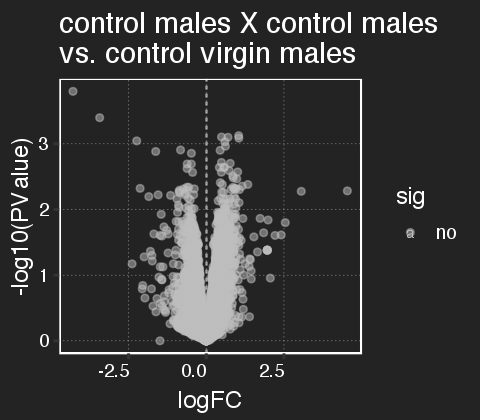

In [172]:
# run the LRT and extract the DE table
CC.effect.table <- edge.DE(dgeList_fit, CA.effect)
CC.effect_sigGenes = subset(CC.effect.table, sig == "yes")$gene

options(repr.plot.width = 4, repr.plot.height = 3.5)
CC.effect_contrasts_volcano.gg = edge.DE.gg(CC.effect.table) +
                                scale_colour_manual(values = c("gray","#f38195")) +
                                geom_text_repel(data = filter(CC.effect.table, sig == "yes" & -log10(PValue) > 5),aes(label=gene_symbol), 
                                force = 10,
                                fontface = "bold", 
                                size = 3) +
                                labs(title = "control males X control males\nvs. control virgin males", size = 2) +
                                theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))
CC.effect_contrasts_volcano.gg

In [230]:
# add a column specifying the sample batch grouping
sampleInfo2 = sampleInfo
sampleInfo2$repGroup = paste(sampleInfo2$Sample, sampleInfo2$Handler, sep = ".")
# set up design matrix for this comparison
repGroups = factor(sampleInfo2$repGroup)
design_reps = model.matrix( ~ 0 + repGroups)
colnames(design_reps) <- levels(repGroups)
rownames(design_reps) <- sampleInfo$Replicate

## Now make the DGE object:
dgeList_rG <- DGEList(counts = countsKeep_bt2, group = repGroups)
dgeList_rG <- calcNormFactors(dgeList_rG)
dgeList_rG <- estimateGLMCommonDisp(dgeList_rG, design_reps)
dgeList_rG <- estimateGLMTagwiseDisp(dgeList_rG, design_reps)
dgeList_rG_fit <- glmQLFit(dgeList_rG, design_reps)
summary(dgeList_rG$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02250 0.04003 0.05093 0.06989 0.07450 2.22087 

Now we'll make the desired contrasts between handler's for each sample group:

In [253]:
design_reps

,AA.Sofie,AA.Yasir,AC.Sofie,AC.Yasir,AO.Sofie,AO.Yasir,CA.Sofie,CA.Yasir,CC.Sofie,CC.Yasir,CO.Sofie,CO.Yasir
AA_1,1,0,0,0,0,0,0,0,0,0,0,0
AA_2,1,0,0,0,0,0,0,0,0,0,0,0
AA_3,0,1,0,0,0,0,0,0,0,0,0,0
AA_4,0,1,0,0,0,0,0,0,0,0,0,0
AC_1,0,0,1,0,0,0,0,0,0,0,0,0
AC_2,0,0,1,0,0,0,0,0,0,0,0,0
AC_3,0,0,0,1,0,0,0,0,0,0,0,0
AC_4,0,0,0,1,0,0,0,0,0,0,0,0
AO_1,0,0,0,0,1,0,0,0,0,0,0,0
AO_2,0,0,0,0,1,0,0,0,0,0,0,0


In [231]:
AO_contrasts <- makeContrasts(AO.Sofie-AO.Yasir, levels=design_reps)
AA_contrasts <- makeContrasts(AA.Sofie-AA.Yasir, levels=design_reps)
AC_contrasts <- makeContrasts(AC.Sofie-AC.Yasir, levels=design_reps)

CO_contrasts <- makeContrasts(CO.Sofie-CO.Yasir, levels=design_reps)
CA_contrasts <- makeContrasts(CA.Sofie-CA.Yasir, levels=design_reps)
CC_contrasts <- makeContrasts(CC.Sofie-CC.Yasir, levels=design_reps)

Run the DE test and make lists of significant genes for each contrast:

In [246]:
# run the LRT and extract the DE table
lrt.AO.table <- edge.DE(dgeList_rG_fit, AO_contrasts)
AO_sigGenes = subset(lrt.AO.table, sig == "yes")$gene

lrt.AA.table <- edge.DE(dgeList_rG_fit, AA_contrasts)
AA_sigGenes = subset(lrt.AA.table, sig == "yes")$gene

lrt.AC.table <- edge.DE(dgeList_rG_fit, AC_contrasts)
AC_sigGenes = subset(lrt.AC.table, sig == "yes")$gene

lrt.CO.table <- edge.DE(dgeList_rG_fit, CO_contrasts)
CO_sigGenes = subset(lrt.CO.table, sig == "yes")$gene

lrt.CA.table <- edge.DE(dgeList_rG_fit, CA_contrasts)
CA_sigGenes = subset(lrt.CA.table, sig == "yes")$gene

lrt.CC.table <- edge.DE(dgeList_rG_fit, CC_contrasts)
CC_sigGenes = subset(lrt.CC.table, sig == "yes")$gene

We can look at volcano plots of DE genes:

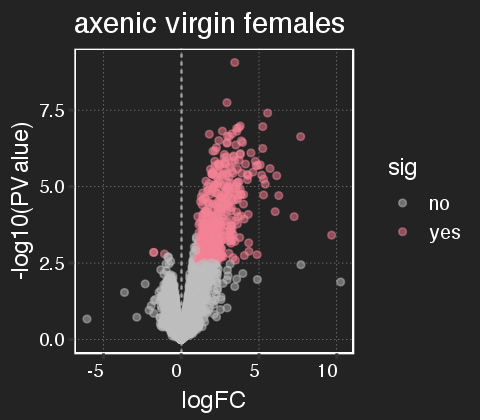

In [247]:
options(repr.plot.width = 4, repr.plot.height = 3.5)
edge.DE.gg(lrt.CC.table) +
    scale_colour_manual(values = c("gray","#f38195")) +
    labs(title = "axenic virgin females", size = 2) +
    theme_monokai_full() + theme(axis.text.x = element_text(angle = 0))

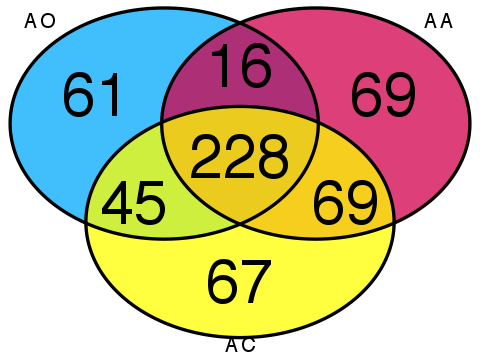

In [249]:
temp_candidates <- list(AO = AO_sigGenes, 
                        AA = AA_sigGenes, 
                        AC = AC_sigGenes)

temp_Vdiag<-venn.diagram(temp_candidates, NULL, fill=c("#01aafb", "#d1004b", "yellow"), alpha=c(0.75,0.75,0.75), cex = 3, cat.fontface= 6, cat.cex = 1, resolution = 100, )

options(repr.plot.width = 4, repr.plot.height =3)
grid.arrange(gTree(children=temp_Vdiag))
rm(temp_candidates, temp_Vdiag)

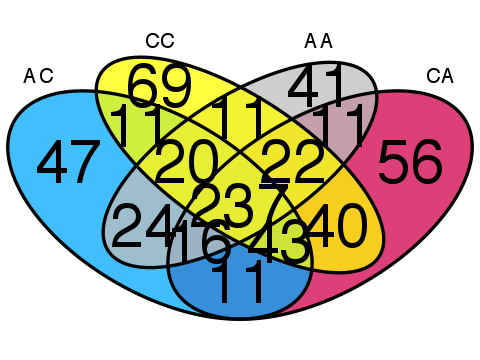

In [251]:
temp_candidates <- list(AC = AC_sigGenes, 
                        CA = CA_sigGenes, 
                        CC = CC_sigGenes,
                        AA = AA_sigGenes)

temp_Vdiag<-venn.diagram(temp_candidates, NULL, fill=c("#01aafb", "#d1004b", "yellow", "gray"), alpha=c(0.75,0.75,0.75, 0.75), cex = 3, cat.fontface= 6, cat.cex = 1, resolution = 100, )

options(repr.plot.width = 4, repr.plot.height =3)
grid.arrange(gTree(children=temp_Vdiag))
rm(temp_candidates, temp_Vdiag)

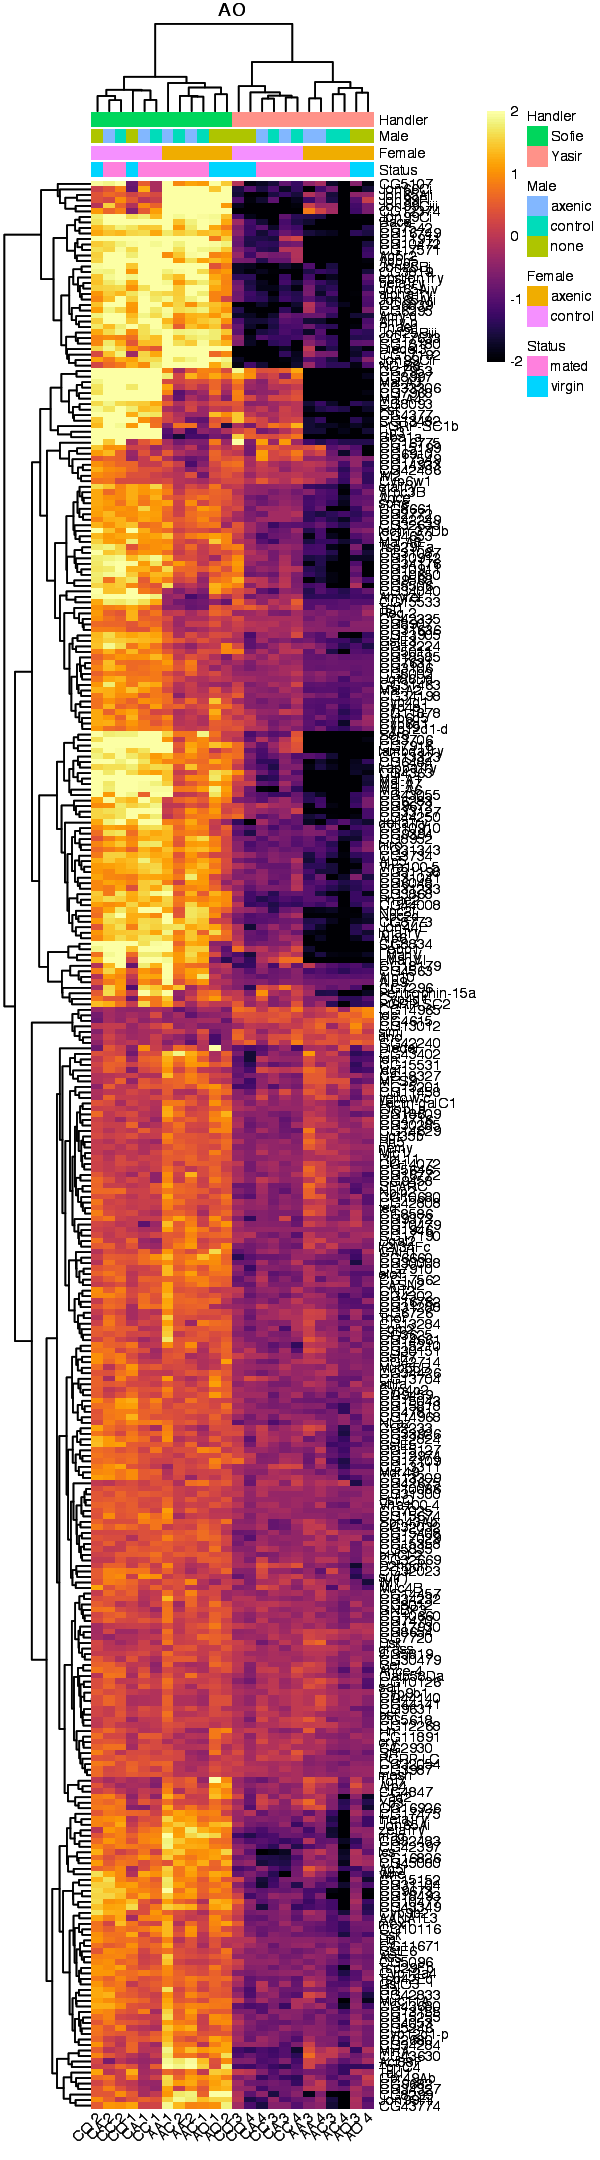

In [252]:
options(repr.plot.width = 5, repr.plot.height = 18)
heatmap_fa2(tpm_bt2, AO_sigGenes, fly_atlas = F, title = "AO")